# Texture Synthesis

Vivek Kwatra, Irfan Essa, Aaron Bobick, and Nipun Kwatra. 2005.
Texture optimization for example-based synthesis. ACM Trans. Graph. 24, 3 (July 2005), 795–802.
https://doi.org/10.1145/1073204.1073263

Copyright © 2005 by the Association for Computing Machinery, Inc

```
This is a Python implementation of 3.2 Multi-level Synthesis in the paper above.
Code is my own work, but the idea is from the paper.
```

texture image size is (64, 64, 3)


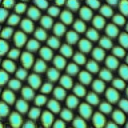

iter 1: loss:1140.8981119791667
iter 2: loss:1099.2096354166667
iter 3: loss:1068.2197265625
iter 4: loss:1046.9108072916667
iter 5: loss:1055.9208984375
iter 6: loss:1031.7311197916667
iter 7: loss:1031.1106770833333
iter 8: loss:1022.3317057291666
iter 9: loss:1035.8828125
iter 10: loss:1014.6513671875
iter 11: loss:1036.8597005208333
iter 12: loss:1013.7373046875
iter 13: loss:1036.9580078125
iter 14: loss:1017.5478515625
iter 15: loss:1032.3681640625
iter 16: loss:1017.5478515625
iter 17: loss:1032.3681640625
iter 18: loss:1017.5478515625
iter 19: loss:1032.3681640625
iter 20: loss:1017.5478515625
iter 21: loss:1032.3681640625
iter 22: loss:1017.5478515625
iter 23: loss:1032.3681640625
iter 24: loss:1017.5478515625
iter 25: loss:1032.3681640625
iter 26: loss:1017.5478515625
iter 27: loss:1032.3681640625
!!!!
iter 28: loss:1052.5091959635417
iter 29: loss:1044.4609375
iter 30: loss:1042.6346842447917
iter 31: loss:1043.0038248697917
iter 32: loss:1040.5318196614583
iter 33: loss:103

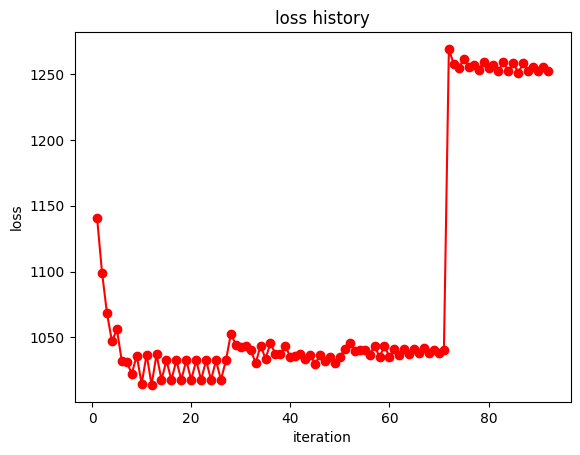

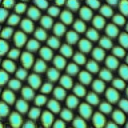

In [73]:
from datetime import datetime

import cv2
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from PIL import Image


### variables
path_to_texture_img = "sample_images/161.jpg"
target_width = 128

texture = cv2.imread(path_to_texture_img)
print("texture image size is", texture.shape)

target = np.random.randint(0, 256, size=(target_width, target_width, 3), dtype=np.uint8)
img_display = display(Image.fromarray(target), display_id=True)


### item for algorithm
current_texture = cv2.resize(texture, (texture.shape[0] // 4, texture.shape[1] // 4))
current_target = cv2.resize(target, (target_width // 4, target_width // 4))
neighbor_width = 8


def init_anchors(target_width, neighbor_width, current_texture):
    indices = np.arange(0, target_width - neighbor_width + 1, neighbor_width // 4)
    x, y = np.meshgrid(indices, indices)
    target_anchors = np.column_stack((y.ravel(), x.ravel()))

    texture_anchors = np.zeros((len(target_anchors), 2), dtype=int)
    texture_anchors[:, 0] = np.random.randint(
        0, current_texture.shape[0] - neighbor_width, size=len(target_anchors)
    )
    texture_anchors[:, 1] = np.random.randint(
        0, current_texture.shape[1] - neighbor_width, size=len(target_anchors)
    )
    return target_anchors, texture_anchors

target_anchors, texture_anchors = init_anchors(
    current_target.shape[0], neighbor_width, current_texture
)

def update_anchors(target_width, neighbor_width, current_texture):
    indices = np.arange(0, target_width - neighbor_width + 1, neighbor_width // 4)
    x, y = np.meshgrid(indices, indices)
    target_anchors = np.column_stack((y.ravel(), x.ravel()))

    texture_anchors = np.zeros((len(target_anchors), 2), dtype=int)
    for i, target_anchor in enumerate(target_anchors):
        y, x = target_anchor
        result = cv2.matchTemplate(
            current_texture,
            current_target[y : y + neighbor_width, x : x + neighbor_width, :],
            method=cv2.TM_SQDIFF,
        )
        _, _, _, max_loc = cv2.minMaxLoc(result)
        texture_anchors[i] = np.array([max_loc[1], max_loc[0]])

    return target_anchors, texture_anchors

loss_history = []
phase = 0
is_transiting = False
iter = 0
last_transition = 5
max_iter = 100

while iter < max_iter:
    iter += 1
    ### scheduling for neighbor_width and resolution
    if phase == 1 and is_transiting:
        transiting = False
        current_texture = cv2.resize(
            texture, (texture.shape[0] // 2, texture.shape[1] // 2)
        )
        current_target = cv2.resize(current_target, (target_width // 2, target_width // 2))
        neighbor_width = 16
        target_anchors, texture_anchors = update_anchors(
            current_target.shape[0], neighbor_width, current_texture
        )
    if phase == 2 and is_transiting:
        is_transiting = False
        current_texture = texture
        current_target = cv2.resize(current_target, (target_width, target_width))
        neighbor_width = 32
        target_anchors, texture_anchors = update_anchors(
            current_target.shape[0], neighbor_width, current_texture
        )
    if phase == 3 and is_transiting:
        is_transiting = False
        max_iter = iter + 20
        neighbor_width = 16
        target_anchors, texture_anchors = update_anchors(
            current_target.shape[0], neighbor_width, current_texture
        )

    # update target to argmin(E(target, texture))
    ref_for_pixel = [
        [] for _ in range(current_target.shape[0] * current_target.shape[1])
    ]

    for target_anchor, texture_anchor in zip(target_anchors, texture_anchors):
        y, x = target_anchor
        yy, xx = texture_anchor
        for i in range(neighbor_width):
            for j in range(neighbor_width):
                ref_for_pixel[(y + i) * current_target.shape[1] + (x + j)].append(
                    current_texture[yy + i, xx + j]
                )

    loss = 0
    for y in range(current_target.shape[0]):
        for x in range(current_target.shape[1]):
            current_target[y, x] = np.mean(
                ref_for_pixel[y * current_target.shape[1] + x], axis=0
            )
            loss += np.sum(
                (ref_for_pixel[y * current_target.shape[1] + x] - current_target[y, x]) ** 2
            )

    mse = loss / (current_target.shape[0] * current_target.shape[1]) / 3
    print(f"iter {iter}: loss:{mse}")

    if  np.sum(loss_history[-10:]) < mse * 10 and last_transition + 20 < iter:
        print("!!!!")
        phase += 1
        is_transiting = True
        last_transition = iter

    loss_history.append(mse)
    img_display.update(
        Image.fromarray(current_target)
    )

    # update texture reference points
    texture_anchors_prev = texture_anchors.copy()

    target_anchors, texture_anchors = update_anchors(
        current_target.shape[0], neighbor_width, current_texture
    )

    if np.all(texture_anchors == texture_anchors_prev):
        break


plt.plot(range(1, len(loss_history) + 1), loss_history, "ro-")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.title("loss history")
plt.show()

target[:, :, :] = current_target
display(Image.fromarray(target))

now = datetime.now()
now = now.strftime("%Y%m%d%H%M%S")
Image.fromarray(target).save(f"synthesized_texture{now}.png")
